In [1]:
%matplotlib inline
import numpy as np
from pylab import*
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from h5py import File
import pandas as pd
from IPython.display import Math
from scipy.special import eval_genlaguerre
import math
from math import gamma, factorial
import json, os
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
from scipy.optimize import curve_fit
from tabulate import tabulate
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Calibration data

In [14]:
# calib_file = "S:\\_Data\\200302 - 3DMM2 cooldown 10 - sideband with LO and mixer\\drive_calibrations\\00000_cavity_transfer_calibration_max0.5gauss_mode2.h5"
calib_file = "Z:\\2020-08-28-StimEm\\drive_calibrations\\00000_2021-02-02_cavity_transfer_calibration_gauss_mode2.h5"

with File(calib_file,'r') as a:
        cal_alpha = array(a['omegas'])
        cal_amp = array(a['amps'])
cal_amp, cal_alpha = zip(*sorted(zip(list(cal_amp), list(cal_alpha))))

cal_amp = array(cal_amp)
cal_alpha = array(cal_alpha)
plt.figure(figsize=(8, 4))
plt.loglog(cal_amp, cal_alpha, 'o')
plt.xlabel("AWG Amplitude")
plt.ylabel('Scale ($\\alpha$ / prep cav len)')
plt.grid(minorticks_on)
plt.show()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'Z:\2020-08-28-StimEm\drive_calibrations\00000_2021-02-02_cavity_transfer_calibration_gauss_mode2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
pd.DataFrame(cal_amp, (cal_alpha*275)**2)

In [ ]:
popt = np.polyfit(cal_amp, cal_alpha, 1)

poly1d_fn = np.poly1d(popt) 
# poly1d_fn is now a function which takes in x and returns an estimate for y
plt.plot(cal_amp, cal_alpha, 'yo', cal_amp, poly1d_fn(cal_amp), '--k')
plt.show()
print(popt)

# Fit functions

In [2]:
def amp_to_ncav(amp, length):
    """Given an AWG amplitude and length of the pulse, it outputs
        the expected number of photons in the storage cavity. 
    """
    m, b = 0.01547743, -0.00013491 #fit parameters from the linear part
#     calib_file = "S:\\_Data\\200302 - 3DMM2 cooldown 10 - sideband with LO and mixer\\drive_calibrations\\00000_cavity_transfer_calibration_max0.5gauss_mode2.h5"
    calib_file = "Z:\\2020-08-28-StimEm\\drive_calibrations\\00000_2021-02-02_cavity_transfer_calibration_gauss_mode2.h5"

    with File(calib_file,'r') as a:
        cal_alpha = array(a['omegas'])
        cal_amp = array(a['amps'])
    cal_amp, cal_alpha = zip(*sorted(zip(list(cal_amp), list(cal_alpha))))
    cal_amp = array(cal_amp)
    cal_alpha = array(cal_alpha)
#     if amp > 0.025:
#         v = m*amp+b
#     elif amp == 0.0:
#         v = 0.0
#     else:
    u = np.argmin(abs(amp-cal_amp))
    v = cal_alpha[u]
    alpha = v*length
    return (alpha)**2*np.exp(-alpha**2)

def photon_counter_line(x, eff):
    return eff*(np.array(x))

def photon_counter_line0(x, eff, err):
    #n = initial Fock state
    n = 0
    return eff*(n+1)*(np.array(x)) + err
#     return (n+1)*(eff*(np.array(x)) + err)

def photon_counter_line1(x, eff, err):
    #n = initial Fock state
    n = 1
    return eff*(n+1)*(np.array(x)) + err
#     return (n+1)*(eff*(np.array(x)) + err)

def ninj_to_nobs(nbar, n, l):
    if l>=n:
        return factorial(n)/(factorial(l)) * nbar**(l-n) * np.exp(-nbar) * (eval_genlaguerre(n, l-n, nbar))**2
    elif l<n:
        return factorial(l)/(factorial(n)) * nbar**(n-l) * np.exp(-nbar) * (eval_genlaguerre(l, n-l, nbar))**2

def th_line(x, eff):
    global n
    Pn_dn = ninj_to_nobs(x, int(n), int(n+1))
    return eff*Pn_dn

def fit_line0(x, eff, err):
    n = 0
    x = np.array(x)
    Pn_dn = ninj_to_nobs(x, n, n+1)
    Fn_dn = ninj_to_nobs(x, n, n+1)/x
    return eff*Pn_dn + err

def fit_line1(x, eff, err):
    n = 1
    x = np.array(x)
    Pn_dn = ninj_to_nobs(x, n, n+1)
    Fn_dn = ninj_to_nobs(x, n, n+1)/x
    return eff*Pn_dn + err

def fit_line3(x, eff, err):
    n = 3
    x = np.array(x)
    Pn_dn = ninj_to_nobs(x, n, n+1)
    Fn_dn = ninj_to_nobs(x, n, n+1)/x
    return eff*Pn_dn + err

def fit_line4(x, eff, err):
    n = 4
    x = np.array(x)
    Pn_dn = ninj_to_nobs(x, n, n+1)
    Fn_dn = ninj_to_nobs(x, n, n+1)/x
    return eff*Pn_dn + err

def fit_line2(x, eff, err):
    n = 1
    x = np.array(x)
    Pn_dn = ninj_to_nobs(x, n, n+1)
    Fn_dn = ninj_to_nobs(x, n, n+1)/x
    xc=1e-4
    y = []
    for i in x:
        if i>=xc:
            Pn_dn = ninj_to_nobs(i-xc, n, n+1)
            y.append(eff*Pn_dn + err)
        else:
            y.append(err)
    return y
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

# n=0 data

In [11]:
data_path =  "../data/stim_em_nobd_nodisc/n0/injected_photon/"
filenames_like = os.listdir(data_path)

th_n = np.logspace(1, 5, 5)
detected_th = {}
detected_th_err = {}
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = np.array(a['alpha'])
        print(np.round(alpha, 6))
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        df = pd.DataFrame(p_n_counts)
        count_n = df[df>th].count()
        t = count_n/len(p_n_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/len(p_n_counts))
    print(r"Total number of events collected: %d, %d events crossed \lambda "%(len(p_n_counts), count_n))
    detected_th[np.round(alpha, 6)]= detect
    detected_th_err[np.round(alpha, 6)] = detect_err

"""Sorts the columns according to injected photon number"""
y0 = pd.DataFrame(detected_th).sort_index(axis=1)
y0err = pd.DataFrame(detected_th_err).sort_index(axis=1)
n0_exp = np.sort(np.array(alphas)**2)

n0_camp_0.0.h5
0.0
Total number of events collected: 10000, 9 events crossed \lambda 
n0_camp_0.001.h5
0.000723
Total number of events collected: 10000, 4 events crossed \lambda 
n0_camp_0.002.h5
0.001447
Total number of events collected: 10000, 8 events crossed \lambda 
n0_camp_0.003.h5
0.00217
Total number of events collected: 10000, 7 events crossed \lambda 
n0_camp_0.004.h5
0.002894
Total number of events collected: 10000, 3 events crossed \lambda 
n0_camp_0.005.h5
0.003617
Total number of events collected: 10000, 3 events crossed \lambda 
n0_camp_0.006.h5
0.004341
Total number of events collected: 10000, 4 events crossed \lambda 
n0_camp_0.007.h5
0.005048
Total number of events collected: 10000, 3 events crossed \lambda 
n0_camp_0.008.h5
0.006113
Total number of events collected: 10000, 5 events crossed \lambda 
n0_camp_0.009.h5
0.006713
Total number of events collected: 10000, 3 events crossed \lambda 
n0_camp_0.01.h5
0.007523
Total number of events collected: 10000, 6 events cro

# n=1 data

In [12]:
data_path =  "../data/stim_em_nobd_nodisc/n1/injected_photon/"
filenames_like = os.listdir(data_path)

th_n = np.logspace(1, 5, 5)
detected_th = {}
detected_th_err = {}
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = np.array(a['alpha'])
        print(np.round(alpha, 6))
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        df = pd.DataFrame(p_n_counts)
        count_n = df[df>th].count()
        t = count_n/len(p_n_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/len(p_n_counts))
    print(r"Total number of events collected: %d, %d events crossed \lambda "%(len(p_n_counts), count_n))
    detected_th[np.round(alpha, 6)]= detect
    detected_th_err[np.round(alpha, 6)] = detect_err

"""Sorts the columns according to injected photon number"""
y1 = pd.DataFrame(detected_th).sort_index(axis=1)
y1err = pd.DataFrame(detected_th_err).sort_index(axis=1)
n1_exp = np.sort(np.array(alphas)**2)

n1_camp_0.0.h5
0.0
Total number of events collected: 10000, 145 events crossed \lambda 
n1_camp_0.001.h5
0.000723
Total number of events collected: 10000, 149 events crossed \lambda 
n1_camp_0.002.h5
0.001447
Total number of events collected: 10000, 146 events crossed \lambda 
n1_camp_0.003.h5
0.00217
Total number of events collected: 10000, 143 events crossed \lambda 
n1_camp_0.004.h5
0.002894
Total number of events collected: 10000, 161 events crossed \lambda 
n1_camp_0.005.h5
0.003617
Total number of events collected: 10000, 112 events crossed \lambda 
n1_camp_0.006.h5
0.004341
Total number of events collected: 10000, 132 events crossed \lambda 
n1_camp_0.007.h5
0.005048
Total number of events collected: 10000, 144 events crossed \lambda 
n1_camp_0.008.h5
0.006113
Total number of events collected: 10000, 131 events crossed \lambda 
n1_camp_0.009.h5
0.006713
Total number of events collected: 10000, 141 events crossed \lambda 
n1_camp_0.01.h5
0.007523
Total number of events collected:

# n=2 data

In [13]:
data_path =  "../data/stim_em_nobd_nodisc/n2/injected_photon/"
filenames_like = os.listdir(data_path)

th_n = np.logspace(1, 5, 5)
detected_th = {}
detected_th_err = {}
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = np.array(a['alpha'])
        print(np.round(alpha, 6))
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        df = pd.DataFrame(p_n_counts)
        count_n = df[df>th].count()
        t = count_n/len(p_n_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/len(p_n_counts))
    print(r"Total number of events collected: %d, %d events crossed \lambda "%(len(p_n_counts), count_n))
    detected_th[np.round(alpha, 6)]= detect
    detected_th_err[np.round(alpha, 6)] = detect_err

"""Sorts the columns according to injected photon number"""
y2 = pd.DataFrame(detected_th).sort_index(axis=1)
y2err = pd.DataFrame(detected_th_err).sort_index(axis=1)
n2_exp = np.sort(np.array(alphas)**2)

n2_camp_0.0.h5
0.0
Total number of events collected: 10000, 0 events crossed \lambda 
n2_camp_0.001.h5
0.000723
Total number of events collected: 10000, 0 events crossed \lambda 
n2_camp_0.002.h5
0.001447
Total number of events collected: 10000, 0 events crossed \lambda 
n2_camp_0.003.h5
0.00217
Total number of events collected: 10000, 0 events crossed \lambda 
n2_camp_0.004.h5
0.002894
Total number of events collected: 10000, 0 events crossed \lambda 
n2_camp_0.005.h5
0.003617
Total number of events collected: 10000, 0 events crossed \lambda 
n2_camp_0.006.h5
0.004341
Total number of events collected: 10000, 0 events crossed \lambda 
n2_camp_0.007.h5
0.005048
Total number of events collected: 10000, 0 events crossed \lambda 
n2_camp_0.008.h5
0.006113
Total number of events collected: 10000, 0 events crossed \lambda 
n2_camp_0.009.h5
0.006713
Total number of events collected: 10000, 0 events crossed \lambda 
n2_camp_0.01.h5
0.007523
Total number of events collected: 10000, 0 events cro

# n=3 data

In [14]:
data_path =  "../data/stim_em_nobd_nodisc//n3/injected_photon/"
filenames_like = os.listdir(data_path)

th_n = np.logspace(1, 5, 5)
detected_th = {}
detected_th_err = {}
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = np.array(a['alpha'])
        print(np.round(alpha, 6))
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        df = pd.DataFrame(p_n_counts)
        count_n = df[df>th].count()
        t = count_n/len(p_n_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/len(p_n_counts))
    print(r"Total number of events collected: %d, %d events crossed \lambda "%(len(p_n_counts), count_n))
    detected_th[np.round(alpha, 6)]= detect
    detected_th_err[np.round(alpha, 6)] = detect_err

"""Sorts the columns according to injected photon number"""
y3 = pd.DataFrame(detected_th).sort_index(axis=1)
y3err = pd.DataFrame(detected_th_err).sort_index(axis=1)
n3_exp = np.sort(np.array(alphas)**2)

n3_camp_0.0.h5
0.0
Total number of events collected: 10000, 0 events crossed \lambda 
n3_camp_0.001.h5
0.000723
Total number of events collected: 10000, 0 events crossed \lambda 
n3_camp_0.002.h5
0.001447
Total number of events collected: 10000, 0 events crossed \lambda 
n3_camp_0.003.h5
0.00217
Total number of events collected: 10000, 0 events crossed \lambda 
n3_camp_0.004.h5
0.002894
Total number of events collected: 10000, 0 events crossed \lambda 
n3_camp_0.005.h5
0.003617
Total number of events collected: 10000, 0 events crossed \lambda 
n3_camp_0.006.h5
0.004341
Total number of events collected: 10000, 0 events crossed \lambda 
n3_camp_0.007.h5
0.005048
Total number of events collected: 10000, 0 events crossed \lambda 
n3_camp_0.008.h5
0.006113
Total number of events collected: 10000, 0 events crossed \lambda 
n3_camp_0.009.h5
0.006713
Total number of events collected: 10000, 0 events crossed \lambda 
n3_camp_0.01.h5
0.007523
Total number of events collected: 10000, 0 events cro

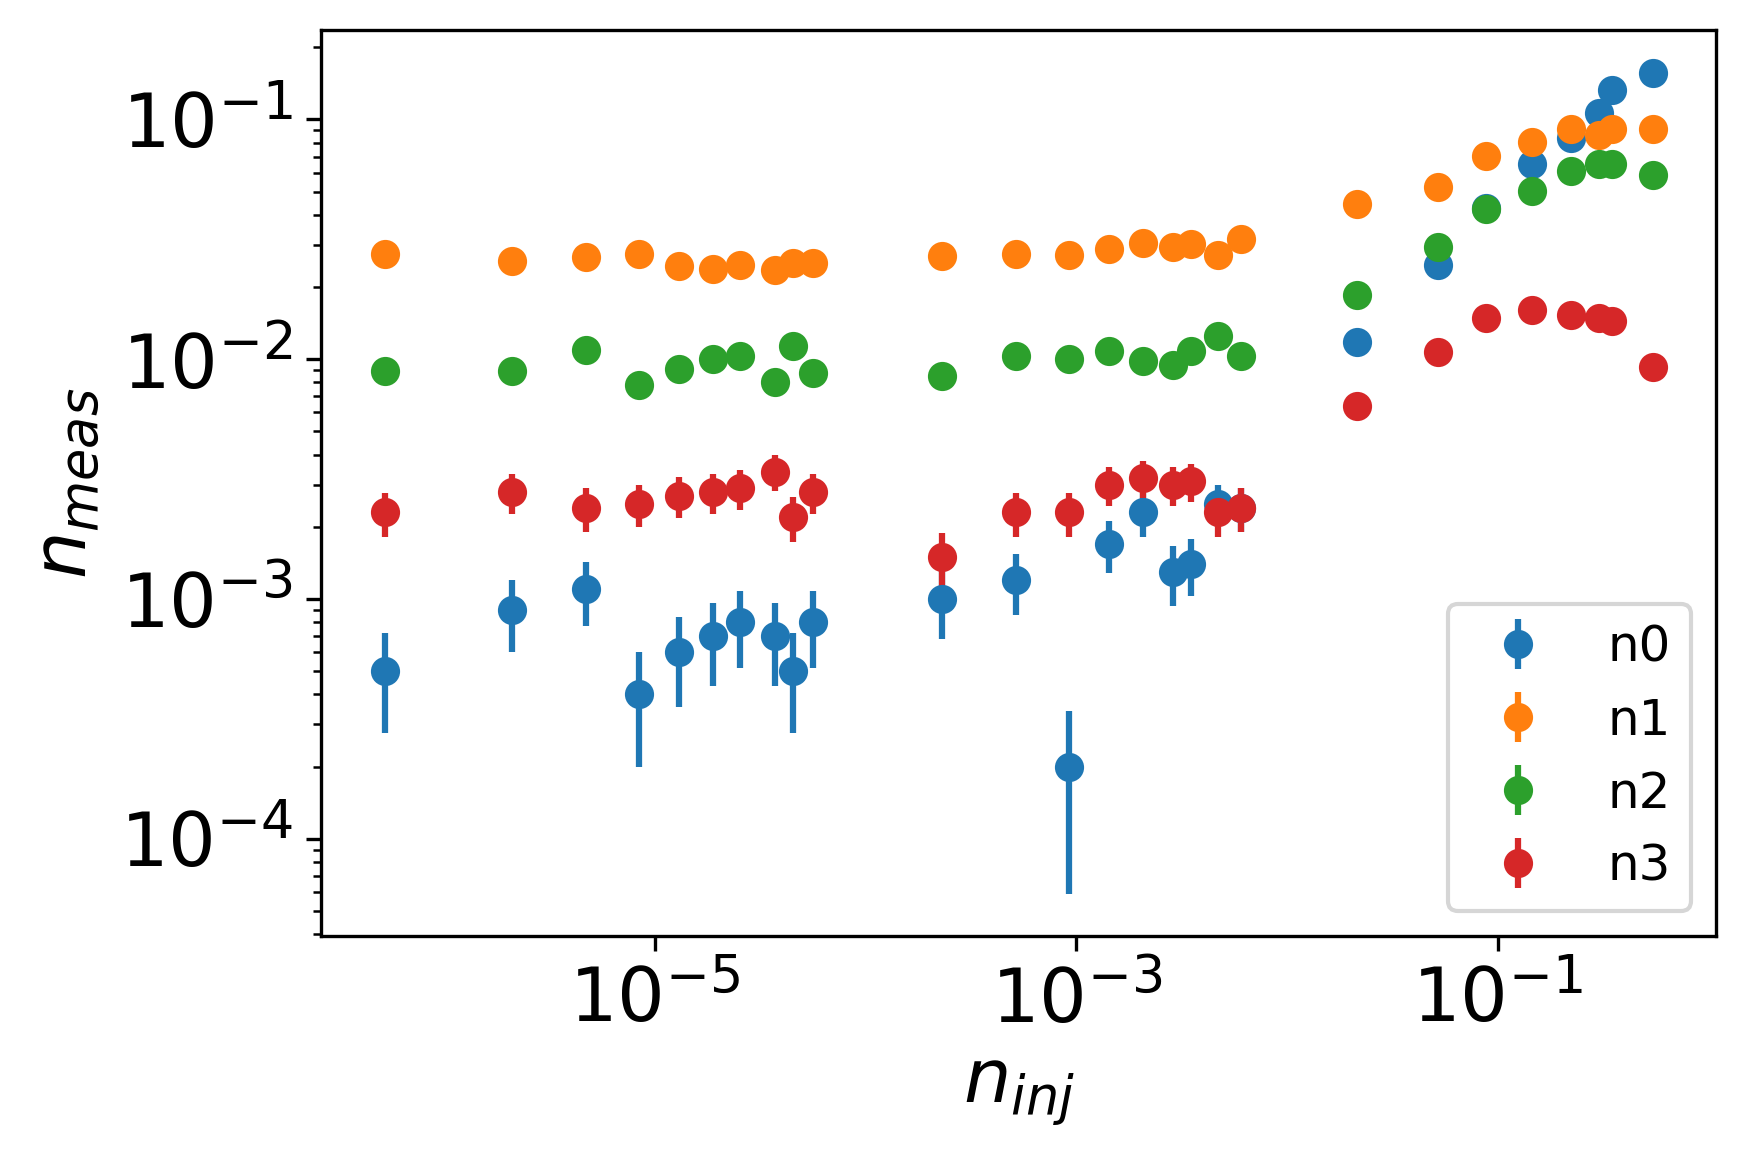

In [16]:
t=2
plt.figure(dpi=300)
plt.errorbar(n0_exp, y= y0.iloc[-t], yerr= y0err.iloc[-t], fmt='o', capthick=4, label='n0')

plt.errorbar(n1_exp, y= y1.iloc[-t], yerr= y1err.iloc[-t], fmt='o', capthick=4, label='n1')

plt.errorbar(n2_exp, y= y2.iloc[-t], yerr= y2err.iloc[-t], fmt='o', capthick=4, label='n2')

plt.errorbar(n3_exp, y= y3.iloc[-t], yerr= y3err.iloc[-t], fmt='o', capthick=4, label='n3')

# plt.errorbar(n3_exp, y= y3.iloc[-t], yerr= y3err.iloc[-t], fmt='o', capthick=4, label='n3')
# plt.title('Conditional qubit reset and self-Kerr correction')
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.legend(loc='lower right', fontsize=12)
plt.show()

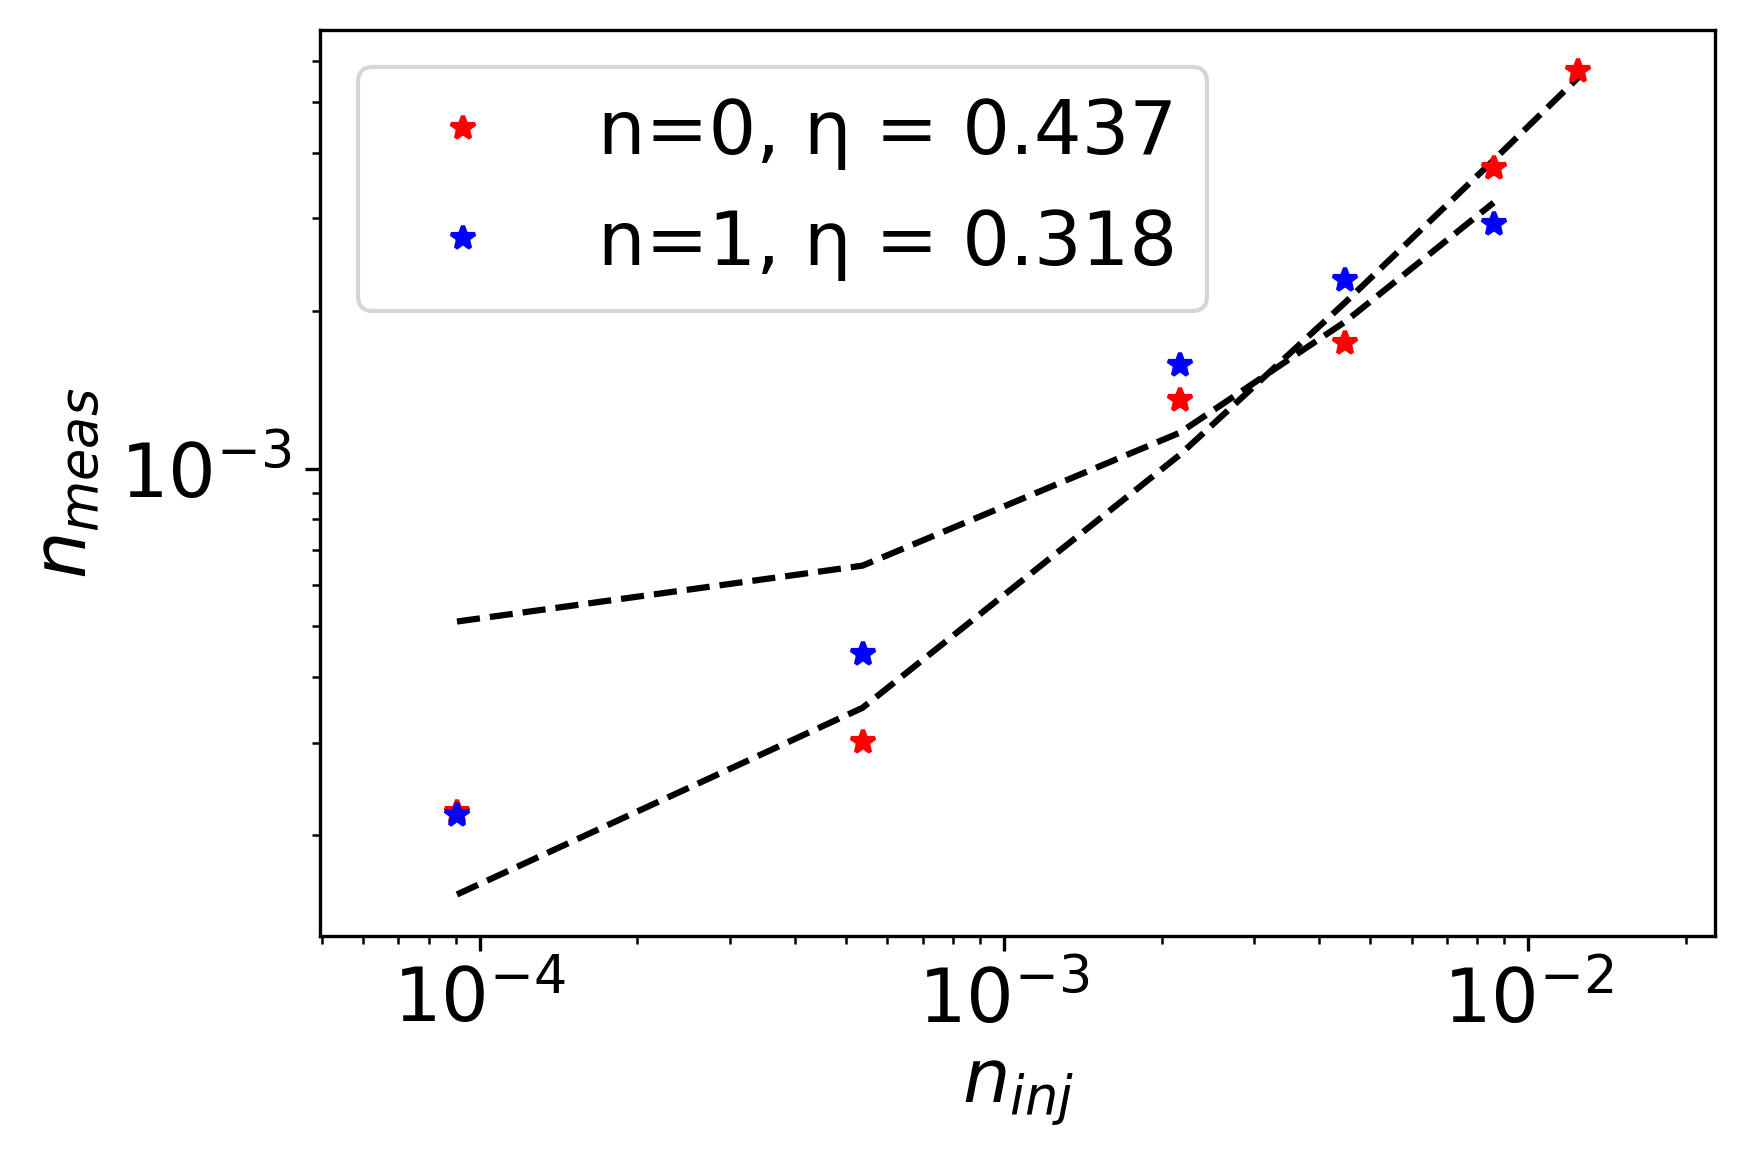

In [20]:
m = 4
x = n0_exp
y = y0.iloc[-m]

plt.figure(dpi=300)
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y
plt.plot(x, poly1d_fn(x), '--k')
plt.plot(x, y, 'r*', label='n=0, η = %.3f'%coef[0])

x = n1_exp
y = y1.iloc[-m]
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y
plt.plot(x, poly1d_fn(x), '--k')
plt.plot(x, y, 'b*', label='n=1, η = %.3f'%coef[0] )

plt.yscale('log')
plt.xscale('log')
plt.axis('equal')
plt.legend(loc='best')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')

plt.show()

In [47]:
coef

array([3.19785032e-01, 1.99510317e-04])

# n=3 data

In [95]:
data_path =  "../data/g3_new//injected_photon/"
filenames_like = os.listdir(data_path)

amps3 = []
n3_exp = []
for jj, filename in enumerate(filenames_like):
#     print(filename)
    filename = data_path + filename
    with File(filename,'r') as f:
        a = (array(f['cav_amp']))
        l = (array(f['length']))
        f.close()
    amps3.append(a)
    n3_exp.append(amp_to_ncav(a, l))

n3_exp , amps3, filenames_like = zip(*sorted(zip(n3_exp, amps3, filenames_like)))

th_m = np.logspace(2, 10, 9)
th_n = 1e2
detected_th = {}
detected_th_err = {}
detected_th_err_bi = {}
state_prep = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_n_oct = array(a['p_n_oct'])
        p_m_oct = array(a['p_m_oct'])
        a.close()
        detect = []
        detect_err = []
        detect_err_bi = []
    for th in th_m:
        count_n = 0
        count_m = 0
        for ii, p in enumerate(zip(p_n_oct, p_m_oct)):
            if p[0] > th_n:
                count_n+=1
            if p[0] > th_n and p[1] > th:
                count_m+=1
        t = count_m/count_n
        eta_initial = count_n/len(p_n_oct)
        detect.append(t)
        detect_err.append(np.sqrt(count_m)/count_n)
        detect_err_bi.append(np.sqrt(t*(1-t)/count_n))
    print(r"Total number of events collected: %d, %d events crossed $\lambda_{th, n}$ and %d events crossed $\lambda_{th, n+1}$"%(len(p_n_oct), count_n, count_m))
    detected_th[n3_exp[jj]] = detect
    detected_th_err[n3_exp[jj]] = detect_err
    detected_th_err_bi[n3_exp[jj]] = detect_err_bi
    state_prep.append(eta_initial)

"""Sorts the columns according to injected photon number"""
y3 = pd.DataFrame(detected_th).sort_index(axis=1)
y3err = pd.DataFrame(detected_th_err).sort_index(axis=1)
y3err_bi = pd.DataFrame(detected_th_err_bi).sort_index(axis=1)

n3_camp_0.01_len_275.h5
Total number of events collected: 58500, 18917 events crossed $\lambda_{th, n}$ and 3 events crossed $\lambda_{th, n+1}$
n3_camp_0.015_len_275.h5
Total number of events collected: 58500, 19345 events crossed $\lambda_{th, n}$ and 2 events crossed $\lambda_{th, n+1}$
n3_camp_0.02_len_275.h5
Total number of events collected: 32750, 6587 events crossed $\lambda_{th, n}$ and 0 events crossed $\lambda_{th, n+1}$
n3_camp_0.025_len_275.h5
Total number of events collected: 30000, 5547 events crossed $\lambda_{th, n}$ and 3 events crossed $\lambda_{th, n+1}$
n3_camp_0.03_len_275.h5
Total number of events collected: 25200, 4453 events crossed $\lambda_{th, n}$ and 2 events crossed $\lambda_{th, n+1}$


# n=4 data

In [53]:
data_path =  "../data/g4/injected_photon/"
filenames_like = os.listdir(data_path)

amps4 = []
n4_exp = []
for jj, filename in enumerate(filenames_like[:2]):
#     print(filename)
    filename = data_path + filename
    with File(filename,'r') as f:
        a = (array(f['cav_amp']))
        l = (array(f['length']))
        f.close()
    amps4.append(a)
    n4_exp.append(amp_to_ncav(a, l))

n4_exp , amps4, filenames_like = zip(*sorted(zip(n4_exp, amps4, filenames_like)))

th_m = np.logspace(2, 10, 9)
th_n = 1e2
detected_th = {}
detected_th_err = {}
detected_th_err_bi = {}
state_prep = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_n_oct = array(a['p_n_oct'])
        p_m_oct = array(a['p_m_oct'])
        a.close()
        detect = []
        detect_err = []
        detect_err_bi = []
    for th in th_m:
        count_n = 0
        count_m = 0
        for ii, p in enumerate(zip(p_n_oct, p_m_oct)):
            if p[0] > th_n:
                count_n+=1
            if p[0] > th_n and p[1] > th:
                count_m+=1
        t = count_m/count_n
        eta_initial = count_n/len(p_n_oct)
        detect.append(t)
        detect_err.append(np.sqrt(count_m)/count_n)
        detect_err_bi.append(np.sqrt(t*(1-t)/count_n))
    print(r"Total number of events collected: %d, %d events crossed $\lambda_{th, n}$ and %d events crossed $\lambda_{th, n+1}$"%(len(p_n_oct), count_n, count_m))
    detected_th[n4_exp[jj]] = detect
    detected_th_err[n4_exp[jj]] = detect_err
    detected_th_err_bi[n4_exp[jj]] = detect_err_bi
    state_prep.append(eta_initial)

"""Sorts the columns according to injected photon number"""
y4 = pd.DataFrame(detected_th).sort_index(axis=1)
y4err = pd.DataFrame(detected_th_err).sort_index(axis=1)
y4err_bi = pd.DataFrame(detected_th_err_bi).sort_index(axis=1)

n4_camp_0.06_len_275.h5
Total number of events collected: 3000, 965 events crossed $\lambda_{th, n}$ and 7 events crossed $\lambda_{th, n+1}$
n4_camp_0.075_len_275.h5
Total number of events collected: 3000, 941 events crossed $\lambda_{th, n}$ and 16 events crossed $\lambda_{th, n+1}$


In [9]:
np.shape(y1), np.shape(y0), np.shape(y3)

((5, 5), (9, 6), (9, 5))

# Higher injected photon number

In [20]:
m = 3
# plt.figure(figsize=(8, 6))
plt.figure(dpi=300)
popt, pcov = curve_fit(f=photon_counter_line, xdata=n0_exp, ydata=y0.iloc[-m], sigma=y0err_bi.iloc[-m])
perr = np.sqrt(pcov)
plt.errorbar(n0_exp, y= y0.iloc[-m], yerr= y0err.iloc[-m], fmt='o', capthick=4, label='n=0, m= %f'%popt, color='b')

x = np.linspace(np.min(n0_exp), np.max(n0_exp), 101)
h = photon_counter_line(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='b')
#########################################
m = 0
popt, pcov = curve_fit(f=photon_counter_line, xdata=n1_exp, ydata=y1.iloc[-m], sigma=y1err_bi.iloc[-m])
perr = np.sqrt(pcov)
plt.errorbar(n1_exp, y= y1.iloc[-m], yerr= y1err.iloc[-m], fmt='o', capthick=4, label='n=1, m= %f'%popt, color='r')

x = np.linspace(np.min(n1_exp), np.max(n1_exp), 101)
h = photon_counter_line(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='r')
#########################################
# m = 3
# popt, pcov = curve_fit(f=photon_counter_line, xdata=n3_exp, ydata=y3.iloc[-m], sigma=y3err_bi.iloc[-m])
# perr = np.sqrt(pcov)
# plt.errorbar(n3_exp, y= y3.iloc[-m], yerr= y3err.iloc[-m], fmt='o', capthick=4, label='n=3, m= %f'%popt, color='g')

# x = np.linspace(np.min(n3_exp), np.max(n3_exp), 101)
# h = photon_counter_line(x, *popt)
# plt.plot(x, h, linewidth=2, linestyle='--', color='g')
# plt.plot(n3_exp, y3.iloc[-m], 'bo')
#########################################
# m = 3
# popt, pcov = curve_fit(f=photon_counter_line, xdata=n4_exp, ydata=y4.iloc[-m], sigma=y4err_bi.iloc[-m])
# perr = np.sqrt(pcov)
# plt.errorbar(n4_exp, y= y4.iloc[-m], yerr= y4err.iloc[-m], fmt='o', capthick=4, label='n=4, m= %f'%popt, color='y')

# x = np.linspace(3e-2, 1e-1, 100001)
# h = photon_counter_line(x, *popt)
# plt.plot(x, h, linewidth=2, linestyle='--', color='y')
# plt.plot(n4_exp, y4.iloc[-m], 'yo')
#########################################

plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
# plt.xscale('symlog', linthreshx=1e-6)
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(1e-2, 5e-2)
# plt.ylim(1e-6, 2e0)
# plt.xlim(np.min(n0_exp), np.max(n0_exp))
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='grey', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.legend(fontsize=10, loc='best')
plt.grid(minorticks_on)
plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 400.

<Figure size 1800x1200 with 0 Axes>

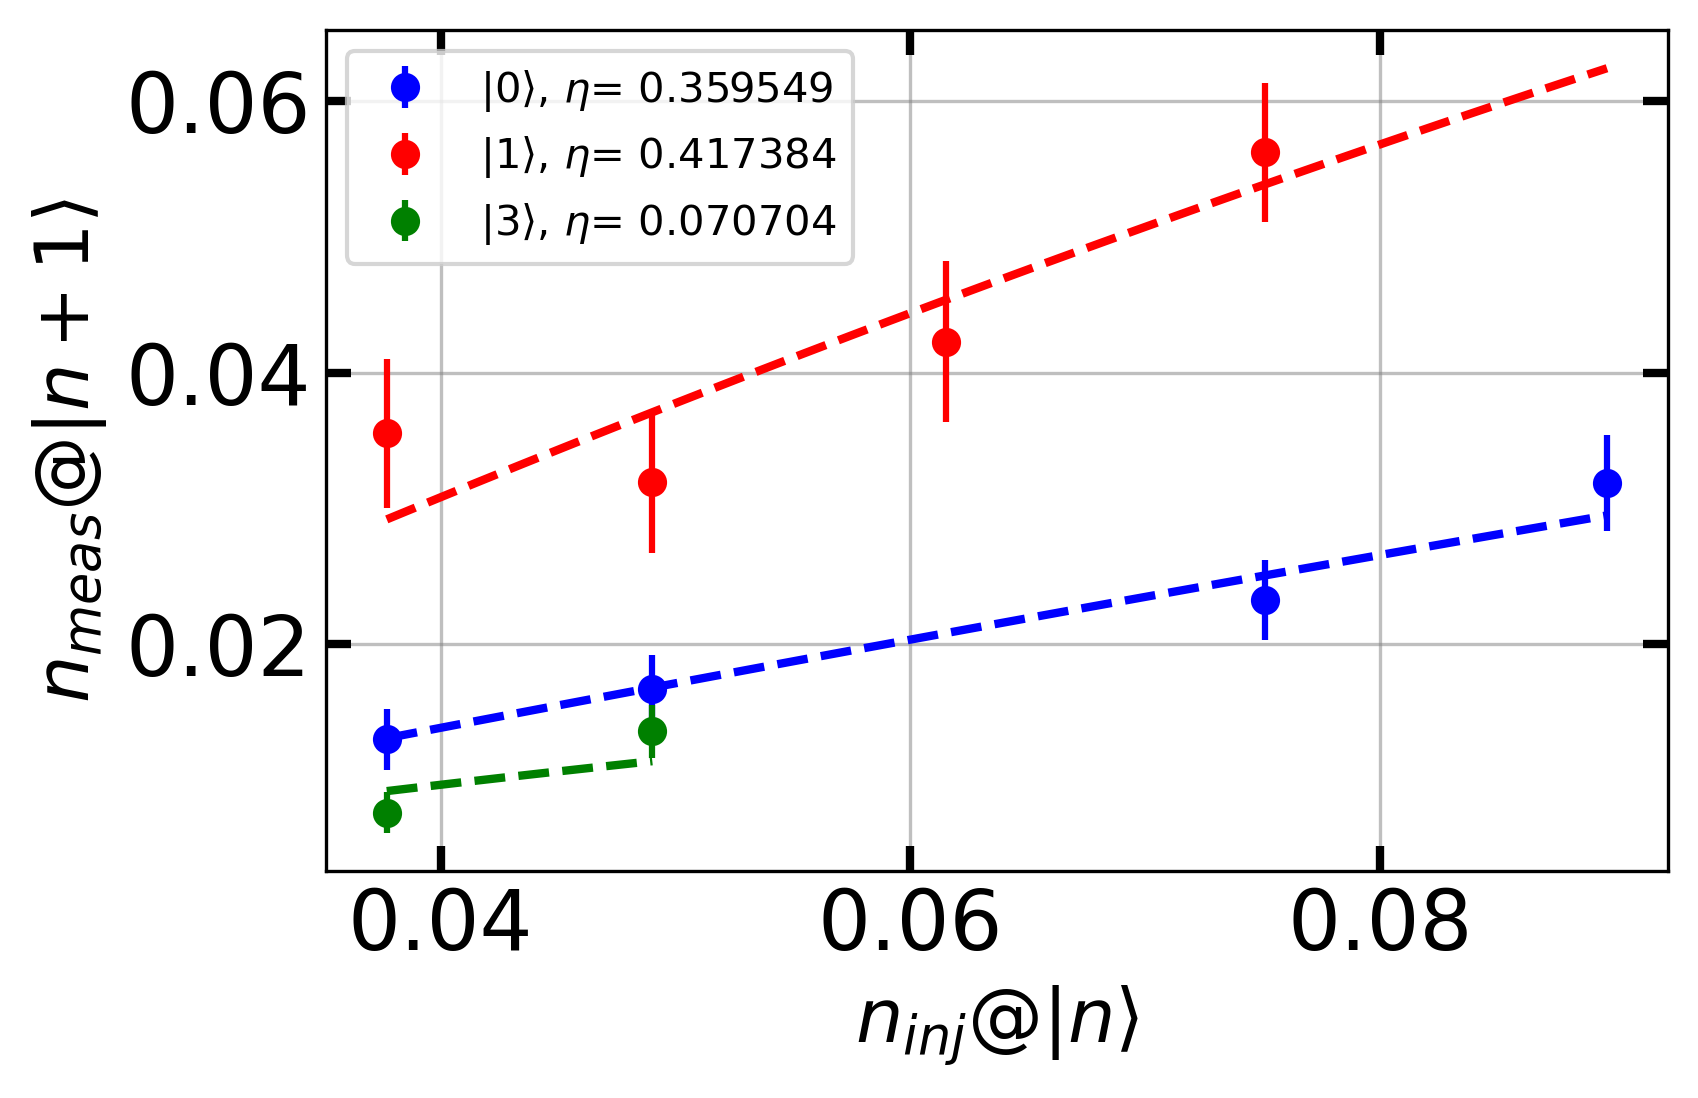

In [129]:
plt.figure(dpi=300)
m = 3
n=0
popt, pcov = curve_fit(f=th_line, xdata=n0_exp, ydata=y0.iloc[-m], sigma=y0err_bi.iloc[-m])
perr = np.sqrt(pcov)
plt.errorbar(n0_exp, y= y0.iloc[-m], yerr= y0err.iloc[-m], fmt='o', capthick=4, label=r'$| 0 \rangle$, $\eta$= %f'%popt, color='b')

x = np.linspace(np.min(n0_exp), np.max(n0_exp), 101)

h = th_line(x, popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='b')
#########################################
m = 3
n=1
popt, pcov = curve_fit(f=th_line, xdata=n1_exp, ydata=y1.iloc[-m], sigma=y1err_bi.iloc[-m])
perr = np.sqrt(pcov)
plt.errorbar(n1_exp, y= y1.iloc[-m], yerr= y1err.iloc[-m], fmt='o', capthick=4, label=r'$| 1 \rangle$, $\eta$= %f'%popt, color='r')

x = np.linspace(np.min(n0_exp), np.max(n0_exp), 101)
h = th_line(x, popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='r')
#########################################
m = 3
n=3
popt, pcov = curve_fit(f=th_line, xdata=n3_exp, ydata=y3.iloc[-m], sigma=y3err_bi.iloc[-m])
perr = np.sqrt(pcov)
plt.errorbar(n3_exp, y= y3.iloc[-m], yerr= y3err.iloc[-m], fmt='o', capthick=4, label=r'$| 3 \rangle$, $\eta$= %f'%popt, color='g')

x = np.linspace(np.min(n3_exp), np.max(n3_exp), 101)
h = th_line(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='g')
#########################################
# m = 3
# n=4
# popt, pcov = curve_fit(f=th_line, xdata=n4_exp, ydata=y4.iloc[-m], sigma=y4err_bi.iloc[-m])
# perr = np.sqrt(pcov)
# plt.errorbar(n4_exp, y= y4.iloc[-m], yerr= y4err.iloc[-m], fmt='o', capthick=4, label='n=4, m= %f'%popt, color='y')

# x = np.linspace(np.min(n4_exp), np.max(n4_exp), 101)
# h = th_line(x, *popt)
# plt.plot(x, h, linewidth=2, linestyle='--', color='y')
#########################################

plt.ylabel(r'$n_{meas} @ | n+1 \rangle$')
plt.xlabel(r'$n_{inj}@ | n \rangle $')
# plt.xscale('symlog', linthreshx=1e-6)
# plt.yscale('log')
# plt.xscale('log')

# plt.ylim(1e-6, 2e0)
# plt.xlim(np.min(n0_exp), np.max(n0_exp))
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='grey', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.legend(fontsize=10, loc='best')
plt.grid(minorticks_on)
plt.show()

No handles with labels found to put in legend.


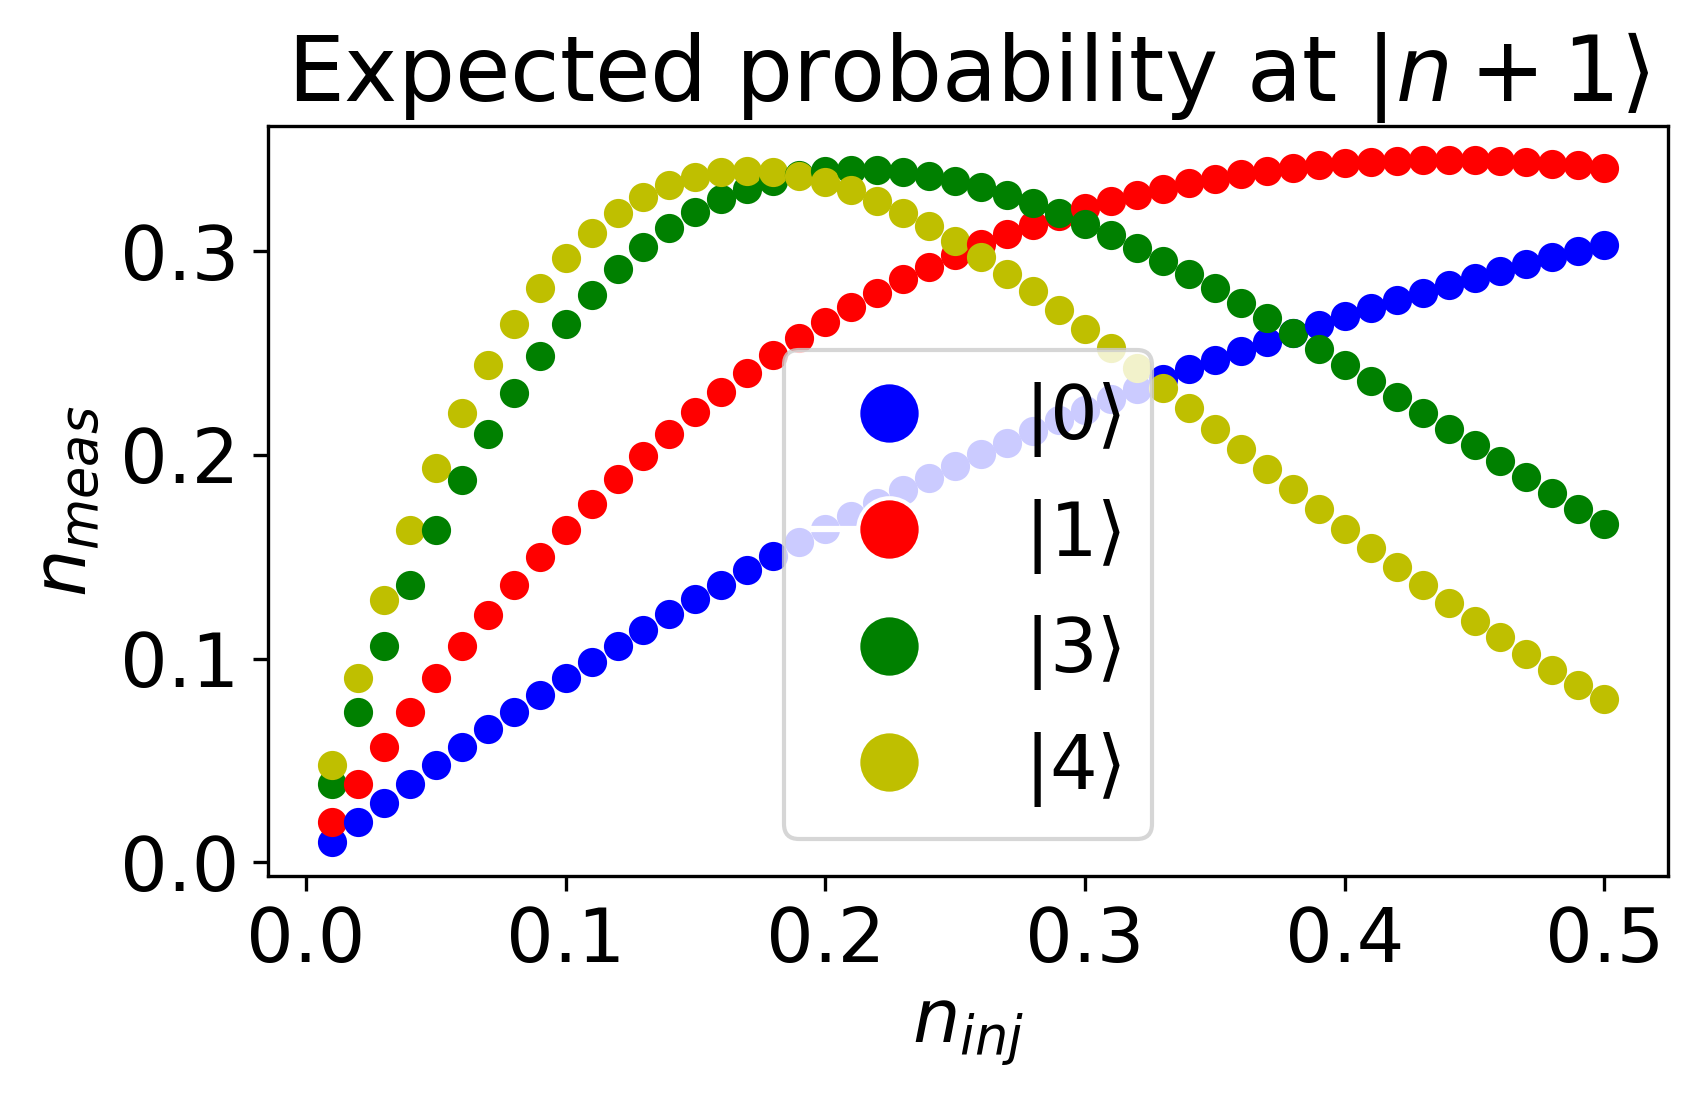

In [104]:
x = np.arange(0.01, 0.51, 0.01)
plt.figure(dpi=300)
for n in x:
    plt.scatter(n, ninj_to_nobs(n, 0, 1), color='b')
    plt.scatter(n, ninj_to_nobs(n, 1, 2), color='r')
    plt.scatter(n, ninj_to_nobs(n, 3, 4), color='g')
    plt.scatter(n, ninj_to_nobs(n, 4, 5), color='y')
plt.legend()

custom_lines = [Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='b', markersize=15),
                Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='r', markersize=15),
                Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='g', markersize=15),
               Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='y', markersize=15)               
               ]

plt.legend(custom_lines, [r'$| 0 \rangle$', r'$| 1 \rangle$', r'$| 3 \rangle$', r'$| 4 \rangle$'])
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.title(r'Expected probability at $| n+1 \rangle$')
plt.tight_layout()
plt.show()

## to the other function

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


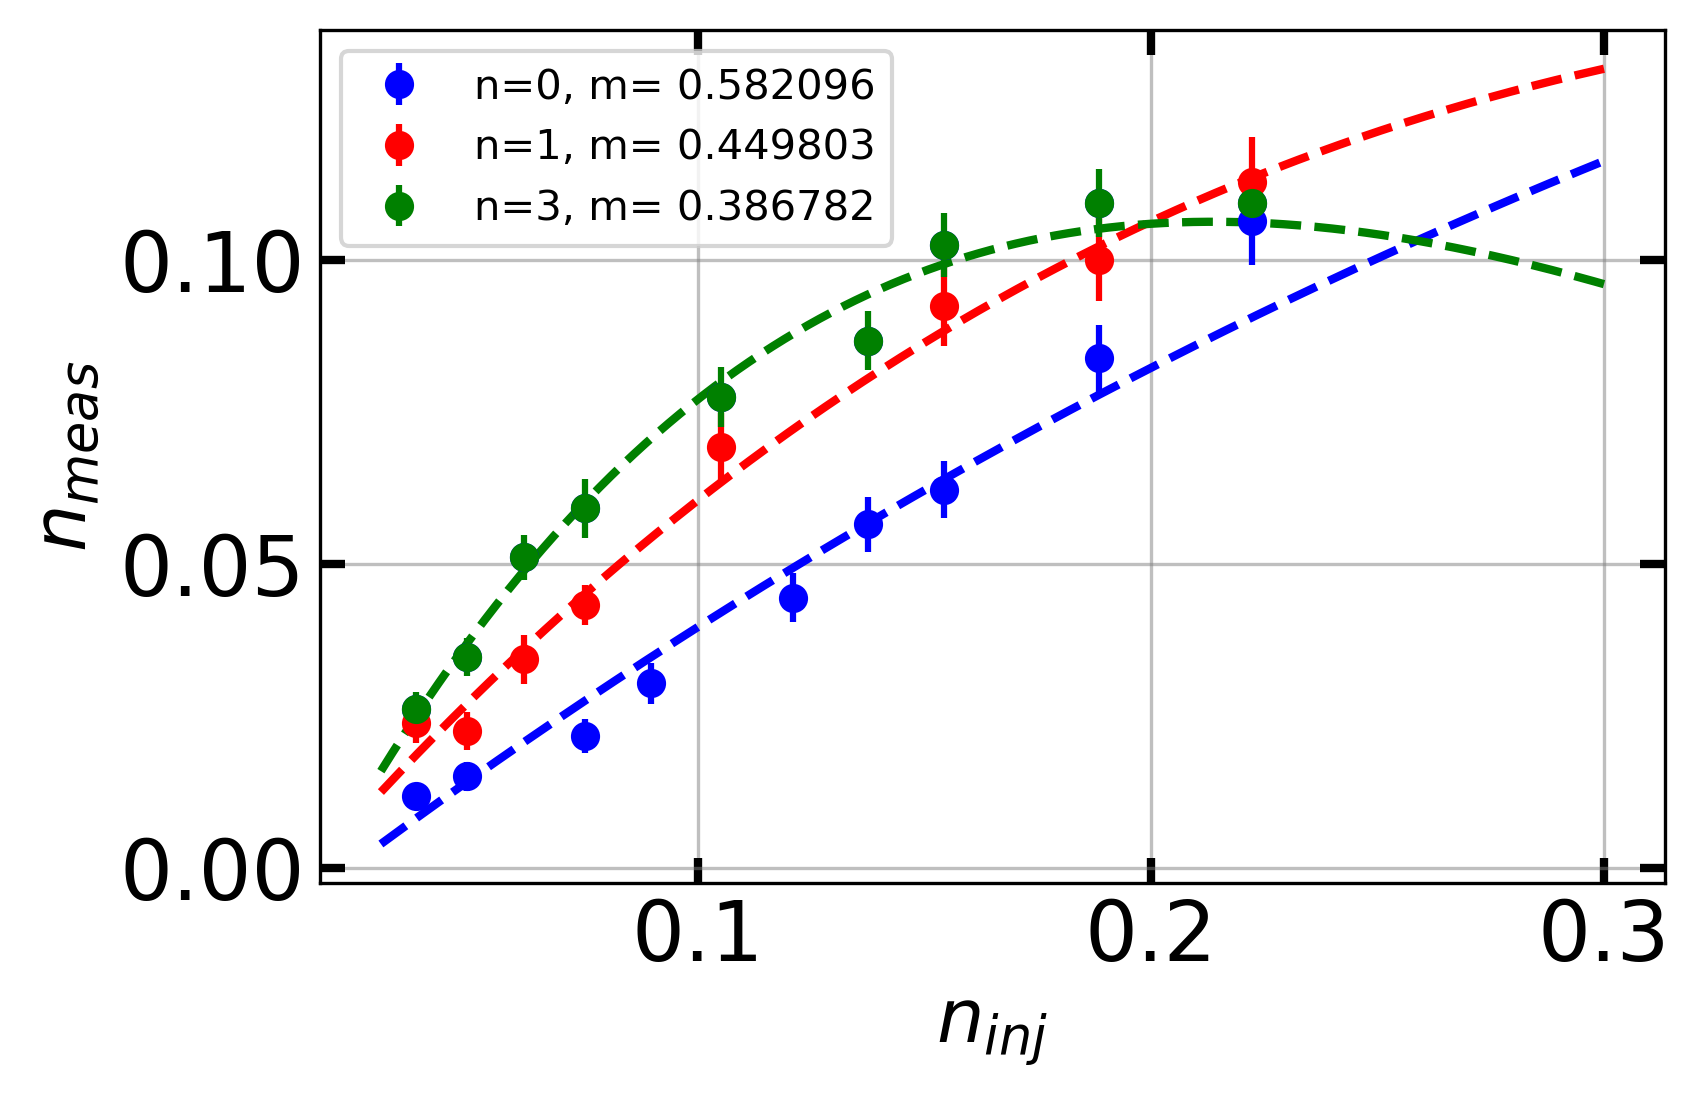

In [105]:
m = 2
# plt.figure(figsize=(8, 6))
plt.figure(dpi=300)
popt, pcov = curve_fit(f=fit_line0, xdata=n0_exp, ydata=y0.iloc[-m], sigma=y0err_bi.iloc[-m])
# perr = np.sqrt(pcov)
plt.errorbar(n0_exp, y= y0.iloc[-m], yerr= y0err.iloc[-m], fmt='o', capthick=4, label='n=0, m= %f'%popt[0], color='b')

x = np.linspace(3e-2, 3e-1, 100001)
h = fit_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='b')
#########################################
m = 4
popt, pcov = curve_fit(f=fit_line1, xdata=n1_exp, ydata=y1.iloc[-m], sigma=y1err_bi.iloc[-m])
# perr = np.sqrt(pcov)
plt.errorbar(n1_exp, y= y1.iloc[-m], yerr= y1err.iloc[-m], fmt='o', capthick=4, label='n=1, m= %f'%popt[0], color='r')

x = np.linspace(3e-2, 3e-1, 100001)
h = fit_line1(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='r')
#########################################
m = 9
popt, pcov = curve_fit(f=fit_line3, xdata=n3_exp, ydata=y3.iloc[-m], sigma=y3err_bi.iloc[-m])
perr = np.sqrt(pcov)
plt.errorbar(n3_exp, y= y3.iloc[-m], yerr= y3err.iloc[-m], fmt='o', capthick=4, label='n=3, m= %f'%popt[0], color='g')

x = np.linspace(3e-2, 3e-1, 100001)
h = fit_line3(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='g')
plt.plot(n3_exp, y3.iloc[-m], 'bo')
#########################################

plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
# plt.xscale('symlog', linthreshx=1e-6)
# plt.yscale('log')
# plt.xscale('log')

# plt.ylim(1e-6, 2e0)
# plt.xlim(np.min(n0_exp), np.max(n0_exp))
plt.tick_params(direction='in', length=6, width=2, colors='k', \
        grid_color='grey', grid_alpha=0.5, labelsize=20, labelbottom=True, right=True, top=True)
plt.tight_layout()
plt.legend(fontsize=10, loc='best')
plt.grid(minorticks_on)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


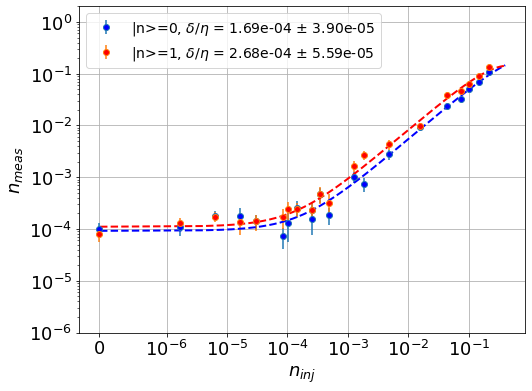

In [6]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 3
plt.figure(figsize=(8, 6))
# plt.figure(dpi=300)
popt, pcov = curve_fit(f=fit_line0, xdata=n0_exp, ydata=y0.iloc[-m], sigma=y0err_bi.iloc[-m], 
                           bounds = ([0.0, 1e-5],[1.0, 1.0]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
plt.errorbar(n0_exp, y= y0.iloc[-m], yerr= y0err.iloc[-m], fmt='o', capthick=4, 
            markerfacecolor='b', label=r'|n>=0, $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))

x = np.linspace(1e-8, 4e-1, 100001)
h = fit_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='b')
########################################################################################################

popt, pcov = curve_fit(f=fit_line1, xdata=n1_exp, ydata=y1.iloc[-m], sigma=y1err_bi.iloc[-m], 
                           bounds = ([0.0, 1e-5],[1.0, 1.0]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
plt.errorbar(n1_exp, y= y1.iloc[-m], yerr= y1err.iloc[-m], fmt='o', capthick=4, 
            markerfacecolor='r', label=r'|n>=1, $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))

x = np.linspace(1e-8, 4e-1, 100001)
h = fit_line1(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='r')

plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthreshx=1e-6)
plt.yscale('log')
plt.ylim(1e-6, 2e0)
# plt.xlim(1e-4, 1e-1)

plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
plt.show()

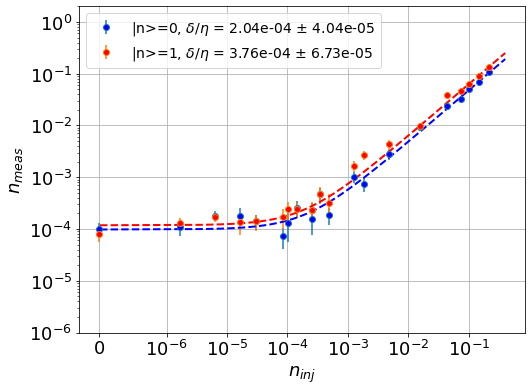

In [7]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 3
plt.figure(figsize=(8, 6))
# plt.figure(dpi=300)

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n0_exp, ydata=y0.iloc[-m], sigma=y0err_bi.iloc[-m], 
                           bounds = ([0.0, 1e-5],[1.0, 1.0]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))


plt.errorbar(n0_exp, y= y0.iloc[-m], yerr= y0err.iloc[-m], fmt='o', capthick=4, 
            markerfacecolor='b', label=r'|n>=0, $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))

x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='b')
#########################################
popt, pcov = curve_fit(f=photon_counter_line1, xdata=n1_exp, ydata=y1.iloc[-m], sigma=y1err_bi.iloc[-m], 
                           bounds = ([0.0, 1e-5],[1.0, 1.0]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))

plt.errorbar(n1_exp, y= y1.iloc[-m], yerr= y1err.iloc[-m], fmt='o', capthick=4, 
            markerfacecolor='r', label=r'|n>=1, $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))

x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line1(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='r')

plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthreshx=1e-6)
plt.yscale('log')
# plt.xscale('log')

plt.ylim(1e-6, 2e0)
# plt.xlim(1e-4, 1e-1)

plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
plt.show()

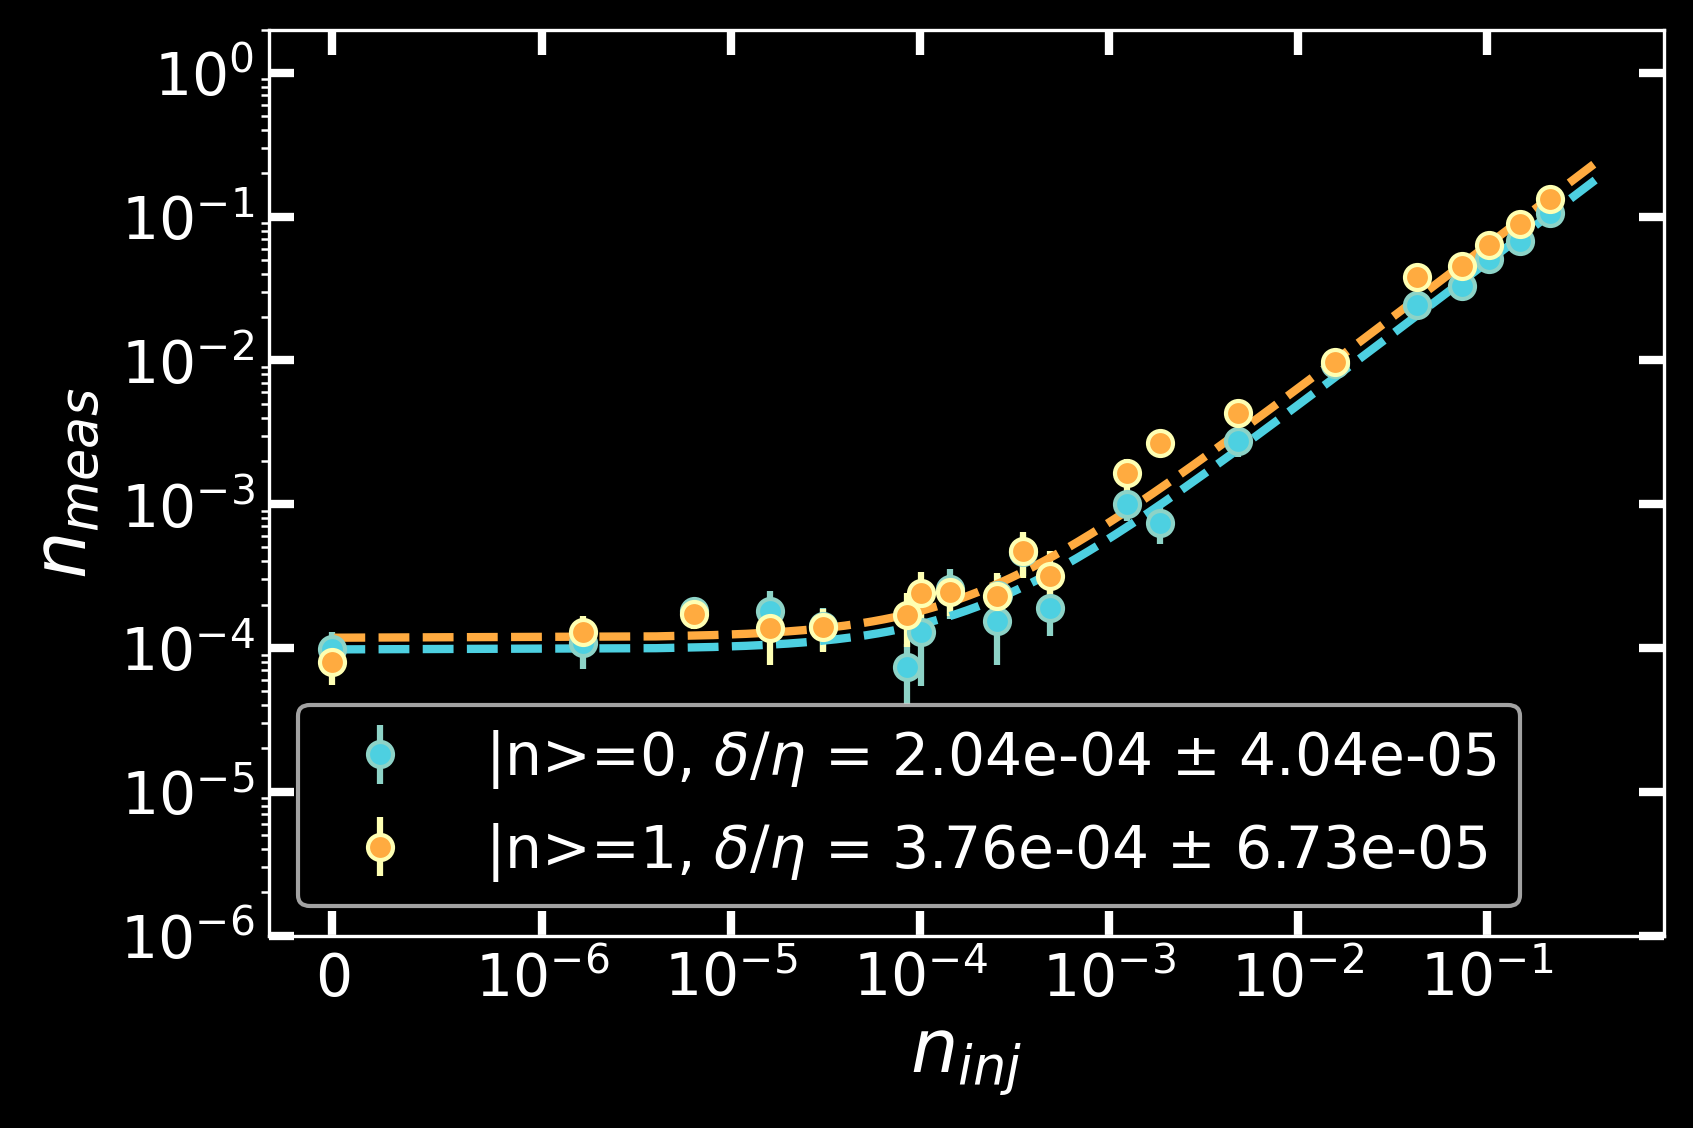

In [11]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 3
# plt.figure(figsize=(8, 6))
plt.figure(dpi=300)
plt.style.use('dark_background')


popt, pcov = curve_fit(f=photon_counter_line0, xdata=n0_exp, ydata=y0.iloc[-m], sigma=y0err_bi.iloc[-m], 
                           bounds = ([0.0, 1e-5],[1.0, 1.0]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))


plt.errorbar(n0_exp, y= y0.iloc[-m], yerr= y0err.iloc[-m], fmt='o', capthick=4, 
            markerfacecolor='#4dd0e1', label=r'|n>=0, $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))

x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#4dd0e1')
#########################################
popt, pcov = curve_fit(f=photon_counter_line1, xdata=n1_exp, ydata=y1.iloc[-m], sigma=y1err_bi.iloc[-m], 
                           bounds = ([0.0, 1e-5],[1.0, 1.0]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))

plt.errorbar(n1_exp, y= y1.iloc[-m], yerr= y1err.iloc[-m], fmt='o', capthick=4, 
            markerfacecolor='#ffab40', label=r'|n>=1, $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))

x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line1(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffab40')

plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthreshx=1e-6)
plt.yscale('log')
# plt.xscale('log')

plt.ylim(1e-6, 2e0)
# plt.xlim(1e-4, 1e-1)
plt.tick_params(direction='in', length=6, width=2, colors='w',\
           grid_color='k', grid_alpha=0.5, labelsize=14, labelbottom=True, right=True,top=True)

plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('Comparen0n1.png', dpi=300, bbox_inches='tight')

plt.show()

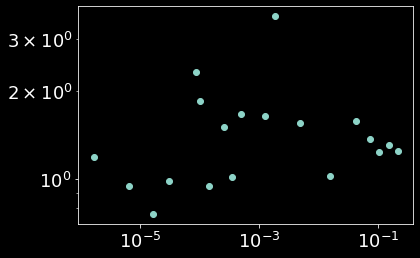

In [17]:
plt.loglog(n0_exp, y1.iloc[-m]/y0.iloc[-m], 'o')
plt.yscale('log')

In [43]:
7e-4*(1-np.exp(-100/2000))

3.413940284950019e-05

In [44]:
# #003f5c
# #58508d
# #bc5090
# #ff6361
# #ffa600
# m = 4
# plt.figure(figsize=(8, 6))
# # plt.figure(dpi=300)
# plt.errorbar(n0_exp, y= y0.iloc[-m], yerr= y0err.iloc[-m], fmt='o', capthick=4, 
#             markerfacecolor='b', label=r'$\lambda_{th, n_{i} =0} =  10^{%.f}$'%(np.log10(th_m[-m])))

# popt, pcov = curve_fit(f=photon_counter_line0, xdata=n0_exp, ydata=y0.iloc[-m], sigma=y0err_bi.iloc[-m], 
#                            bounds = ([0.0, 1e-5],[1.0, 1.0]))
# perr = np.sqrt(np.diag(pcov))
# x = np.linspace(1e-8, 4e-1, 100001)
# h = fit_line2(x, *popt)
# plt.plot(x, h, linewidth=2, linestyle='--', color='b')
# print(r'Efficiency = {:^.2f} +/- {:^.3f} delta = {:^.2e} +/- {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
# #########################################
# plt.errorbar(n1_exp, y= y1.iloc[-m], yerr= y1err.iloc[-m], fmt='o', capthick=4, 
#             markerfacecolor='r', label=r'$\lambda_{th, n_{i} =1} =  10^{%.f}$'%(np.log10(th_m[-m])))

# popt, pcov = curve_fit(f=fit_line2, xdata=n1_exp, ydata=y1.iloc[-m], sigma=y1err_bi.iloc[-m], 
#                            bounds = ([0.0, 1e-5],[1.0, 1.0]))
# perr = np.sqrt(np.diag(pcov))
# x = np.linspace(1e-8, 4e-1, 100001)
# h = fit_line2(x, *popt)
# plt.plot(x, h, linewidth=2, linestyle='--', color='r')

# plt.ylabel(r'$n_{meas}$')
# plt.xlabel(r'$n_{inj}$')
# plt.xscale('symlog', linthreshx=1e-6)
# plt.yscale('log')
# plt.ylim(1e-5, 2e0)
# # plt.text(1e-2, 5e-4, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n $\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
# # plt.text(1e-6, 5e-2, 'Efficiency corrected \n dark count rate,\
# #         \n $\delta$/$\eta$ = {:<.2e}'.format(popt[1]/(popt[0])))
# # plt.legend(fontsize=14, bbox_to_anchor=(1.05, 1)) 
# plt.legend(fontsize=14, loc='best') 
# plt.grid(minorticks_on)
# plt.show()
# print(r'Efficiency = {:^.2f} +/- {:^.3f} delta = {:^.2e} +/- {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))

In [151]:
# directory = "../data/g0_new/"
# # camp = [0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08]
# camp = np.arange(0.01, 0.036, 0.005)
# for amp in camp:
#     os.makedirs(directory+"camp_"+str(round(amp, 3))+"_275")

In [23]:
377/(1.123e-3*(10)**(2/3))

72326.07997702762